# X5 - Basic EDA

1. Explore data
2. Try to find a way to apply M5 pipleine to X5 data

In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

#from scipy.stats import kurtosis
#from scipy.stats import skew
#from scipy import stats

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.sparse import csr_matrix

from sklearn.preprocessing import RobustScaler

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook as tqdm
import gc

%matplotlib inline

In [2]:
# Memory reduction helper function:
def reduce_mem_usage(df, fp16 = False, verbose=True):
    '''
    Memory reduction helper function.
    Be careful with np.float16 it is not supported by a lot of packages.
    '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if fp16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Load Data:

In [3]:
path = 'C:/Users/daug/Desktop/DataMonetize Data/purchases-002.parquet'
cols = ['transaction_datetime','store_id','product_id','product_quantity']#'trn_sum_from_iss',
grid_df = pd.read_parquet(path, columns=cols)

In [6]:
# Data types:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57249006 entries, 0 to 57249005
Data columns (total 4 columns):
 #   Column                Dtype         
---  ------                -----         
 0   transaction_datetime  datetime64[ns]
 1   store_id              object        
 2   product_id            object        
 3   product_quantity      object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.7+ GB


In [7]:
# Change to correct data types:
grid_df.columns = ['timestamp','location','item_id','demand']#'price',
grid_df.loc[:,'timestamp'] = grid_df['timestamp'].dt.normalize()#date.astype('category') #normalize() #.date() #pd.to_datetime(grid_df.timestamp)
#grid_df.loc[:,'price'] = pd.to_numeric(grid_df.price, downcast='float', errors='coerce')
grid_df.loc[:,'demand'] = pd.to_numeric(grid_df.demand, downcast='float', errors='coerce')
grid_df.loc[:,'location'] = grid_df.location.astype('category')
grid_df.loc[:,'item_id'] = grid_df.item_id.astype('category')

In [8]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57249006 entries, 0 to 57249005
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   location   category      
 2   item_id    category      
 3   demand     float32       
dtypes: category(2), datetime64[ns](1), float32(1)
memory usage: 985.1 MB


### Group Demand by Day-Location-Item:

In [9]:
# As there is no apparent way to backengineer product prices, we will stick with demand only. 
#grid_df = grid_df.groupby(['timestamp','location','item_id'], observed=True).agg({'price':'sum','demand':'sum'}).reset_index()
grid_df = grid_df.groupby(['timestamp','location','item_id'], observed=True).sum().reset_index()

### Basic EDA:

In [4]:
# Lets see where time series starts:
grid_df.transaction_datetime.min()

Timestamp('2018-11-21 21:02:33')

In [5]:
# And where it ends:
grid_df.transaction_datetime.max()

Timestamp('2019-03-18 23:40:03')

In [18]:
# Ok so we have only 4 month of data. How many stores/items do we have?
print(len(grid_df.location.unique()), len(grid_df.item_id.unique()))

13884 43038


### Weird insights
Ok, so we have data on 13,884 store and 43038 items.  13,884 X 43,038 = 597,539,592 store-item pairs.
But we only have 53,084,721 datapoints, so lots of shop-item pairs are nonexistent.

In this case there is no point in forecasting at store-item level.

In [10]:
# Sanity check: purchases of an item in a store:
m1 = grid_df.item_id=='4009f09b0457b42658dc1df641c75a3d'
m2 = grid_df.location == '422af85d1662893fda552adc0da1a411'
grid_df.loc[m1&m2,'demand'].plot.line(x='demand', y='timestamp')

,timestamp,location,item_id,demand
69530,2018-11-22,422af85d1662893fda552adc0da1a411,4009f09b0457b42658dc1df641c75a3d,3.0
473277,2018-11-23,422af85d1662893fda552adc0da1a411,4009f09b0457b42658dc1df641c75a3d,2.0
912269,2018-11-24,422af85d1662893fda552adc0da1a411,4009f09b0457b42658dc1df641c75a3d,1.0
1321931,2018-11-25,422af85d1662893fda552adc0da1a411,4009f09b0457b42658dc1df641c75a3d,1.0
1702994,2018-11-26,422af85d1662893fda552adc0da1a411,4009f09b0457b42658dc1df641c75a3d,2.0
...,...,...,...,...
50470383,2019-03-14,422af85d1662893fda552adc0da1a411,4009f09b0457b42658dc1df641c75a3d,4.0
51052409,2019-03-15,422af85d1662893fda552adc0da1a411,4009f09b0457b42658dc1df641c75a3d,1.0
51669515,2019-03-16,422af85d1662893fda552adc0da1a411,4009f09b0457b42658dc1df641c75a3d,2.0
52193329,2019-03-17,422af85d1662893fda552adc0da1a411,4009f09b0457b42658dc1df641c75a3d,2.0


In [10]:
# Apparently there are a lot of items that should be considered slow movers. (Or we are only given a fraction of the actual demand.)
# Lets see the demand max:
grid_df.demand.max()

14941.0

In [11]:
# The max look ssuspicious, lets remove all outliers. 
# Note we will not remove outliers per group, as we have only 4 month of history with 3 major holidays.

percentiles = grid_df['demand'].quantile([0.001,0.99]).values
grid_df['demand'] = np.clip(grid_df['demand'], percentiles[0], percentiles[1])

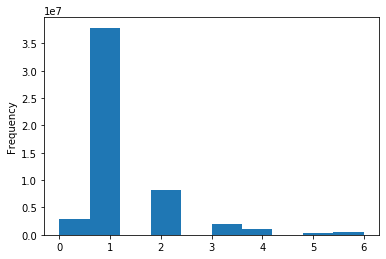

In [12]:
grid_df.demand.plot.hist()

### Fraction of time-series
Ok it is confirmed we are given only fractions of the actual timeseries.
As if 98% of items only sold once or twice per day X5 would have gone out of business.

More likely sales has been random sampled by customers. So location should be dropeed al together then we might have a represnetnative sample of demand for products (albeit a tiny fraction of the real demand).

In [21]:
grid_df = grid_df.groupby(['timestamp','item_id'], observed=True).sum().reset_index()

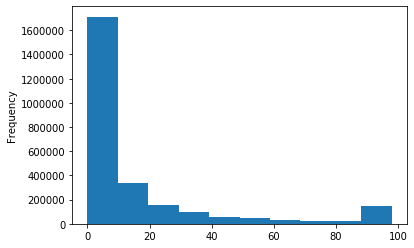

In [25]:
percentiles = grid_df['demand'].quantile([0.001,0.99]).values
grid_df['demand'] = np.clip(grid_df['demand'], percentiles[0], percentiles[1])
grid_df.demand.plot.hist()

# Week aggregations
1. Aggregate by week
2. Go from long to wide format with index by "item_id"

In [38]:
grid_df.loc[:,'week'] = (grid_df.timestamp - grid_df.timestamp.min()
                        ).astype('timedelta64[h]').div(24*7).apply(np.ceil).astype(np.int16)

In [39]:
grid_df.head()

,timestamp,item_id,demand,week
0,2018-11-21,bf07df54e1930007929bd31d8426c8e4,4.0,0
1,2018-11-21,4009f09b0457b42658dc1df641c75a3d,14.0,0
2,2018-11-21,5c6de3010fd8fce653d43f0ee8d3f7bd,2.0,0
3,2018-11-21,a755a6f2e63f065b40aa5007941f563f,1.0,0
4,2018-11-21,d889d4fb278a12dbe8500955bd926847,1.0,0


In [42]:
# Aggreagte by week:
grid_df = grid_df.groupby(['week','item_id'], observed=True).sum().reset_index()

# To make out life a little easier cast categories to category codes:
grid_df.loc[:,'item_id'] = grid_df.item_id.cat.codes
grid_df.head()

,week,item_id,demand
0,0,31933,4.0
1,0,10810,14.0
2,0,15506,2.0
3,0,27971,1.0
4,0,36391,1.0


# Stationary Weekly Dataset
1. log
2. minus lag52
3. minus lag4

In [14]:
def substract_lag(col, lag):
    '''
    Substracts lag x from column.
    '''
    return (roll_week_df[col] - roll_week_df.groupby(['id'])[col].transform(lambda x: x.shift(lag))).astype(np.float32)

In [15]:
# Create stationary timeseries:
columns_to_modify = ['sales', 'clean_sales']
for col in columns_to_modify:
    roll_week_df.loc[:,f'{col}_log'] = np.log(roll_week_df.loc[:,col]+1)
    roll_week_df.loc[:,f'{col}_log_52'] = substract_lag(f'{col}_log', 52)
    roll_week_df.loc[:,f'{col}_log_52_4'] = substract_lag(f'{col}_log_52', 4)

### Plot & Test for Stationarity

In [47]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        #p_value = sm.tsa.stattools.adfuller(y)[1]
        #ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

ValueError: negative dimensions are not allowed

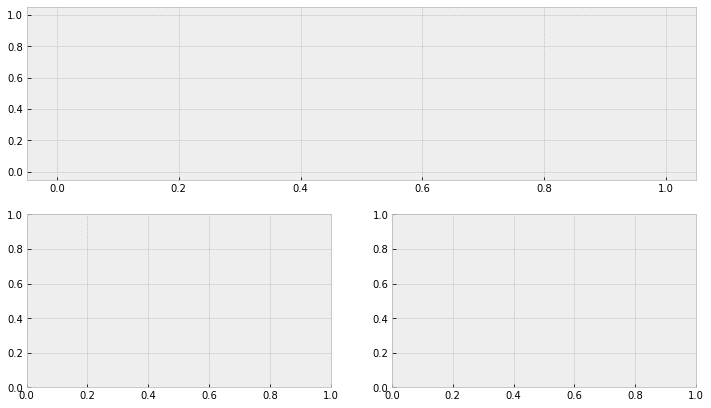

In [50]:
id_mask = grid_df.item_id=='1'
#test_mask = roll_week_df.wm_yr_wk_x < (roll_week_df.wm_yr_wk_x.max() - 4)
#lag_mask = roll_week_df.wm_yr_wk_x > (roll_week_df.wm_yr_wk_x.min() + 104)

ts = grid_df.loc[id_mask,'demand']
tsplot(ts, lags=10)

# Results

Unfortunatley the data timespan is too short to even do Dickey-Fuller test on weekly aggreagated dataset. However, daily dataset is way too noisy to spot anything but weekend spike in sales.